# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.0321
Epoch 1/200, Iteration 2/12, Loss: 0.9864
Epoch 1/200, Iteration 3/12, Loss: 0.8412
Epoch 1/200, Iteration 4/12, Loss: 0.6488
Epoch 1/200, Iteration 5/12, Loss: 0.8411
Epoch 1/200, Iteration 6/12, Loss: 0.6380
Epoch 1/200, Iteration 7/12, Loss: 0.7789
Epoch 1/200, Iteration 8/12, Loss: 0.5599
Epoch 1/200, Iteration 9/12, Loss: 0.5018
Epoch 1/200, Iteration 10/12, Loss: 0.4345
Epoch 1/200, Iteration 11/12, Loss: 0.3654
Epoch 1/200, Iteration 12/12, Loss: 0.3101
Epoch 1/200, Iteration 13/12, Loss: 0.2564
Train Error: 
 Accuracy: 67.12%, Avg loss: 0.255176, MRE: 0.220555, MAE: 0.054431 

Test Error: 
 Accuracy: 66.5%, Avg loss: 0.250862, MRE: 0.195379, MAE: 0.056610 

Epoch 2/200, Iteration 1/12, Loss: 0.2760
Epoch 2/200, Iteration 2/12, Loss: 0.1501
Epoch 2/200, Iteration 3/12, Loss: 0.2353
Epoch 2/200, Iteration 4/12, Loss: 0.1925
Epoch 2/200, Iteration 5/12, Loss: 0.1730
Epoch 2/200, Iteration 6/12, Loss: 0.1721
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 97.62%, Avg loss: 0.005953, MRE: 0.031173, MAE: 0.006087 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004864, MRE: 0.027334, MAE: 0.006259 

Epoch 13/200, Iteration 1/12, Loss: 0.0043
Epoch 13/200, Iteration 2/12, Loss: 0.0206
Epoch 13/200, Iteration 3/12, Loss: 0.0077
Epoch 13/200, Iteration 4/12, Loss: 0.0028
Epoch 13/200, Iteration 5/12, Loss: 0.0076
Epoch 13/200, Iteration 6/12, Loss: 0.0061
Epoch 13/200, Iteration 7/12, Loss: 0.0044
Epoch 13/200, Iteration 8/12, Loss: 0.0055
Epoch 13/200, Iteration 9/12, Loss: 0.0062
Epoch 13/200, Iteration 10/12, Loss: 0.0050
Epoch 13/200, Iteration 11/12, Loss: 0.0030
Epoch 13/200, Iteration 12/12, Loss: 0.0064
Epoch 13/200, Iteration 13/12, Loss: 0.0053
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.006173, MRE: 0.030213, MAE: 0.005988 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003656, MRE: 0.025907, MAE: 0.005682 

Epoch 14/200, Iteration 1/12, Loss: 0.0104
Epoch 14/200, Iteration 2/12, Loss: 0.0039
Epoch 14/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001865, MRE: 0.020631, MAE: 0.004078 

Epoch 25/200, Iteration 1/12, Loss: 0.0032
Epoch 25/200, Iteration 2/12, Loss: 0.0030
Epoch 25/200, Iteration 3/12, Loss: 0.0046
Epoch 25/200, Iteration 4/12, Loss: 0.0032
Epoch 25/200, Iteration 5/12, Loss: 0.0015
Epoch 25/200, Iteration 6/12, Loss: 0.0028
Epoch 25/200, Iteration 7/12, Loss: 0.0034
Epoch 25/200, Iteration 8/12, Loss: 0.0019
Epoch 25/200, Iteration 9/12, Loss: 0.0022
Epoch 25/200, Iteration 10/12, Loss: 0.0060
Epoch 25/200, Iteration 11/12, Loss: 0.0022
Epoch 25/200, Iteration 12/12, Loss: 0.0014
Epoch 25/200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002662, MRE: 0.023581, MAE: 0.004135 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002483, MRE: 0.020737, MAE: 0.004149 

Epoch 26/200, Iteration 1/12, Loss: 0.0015
Epoch 26/200, Iteration 2/12, Loss: 0.0034
Epoch 26/200, Iteration 3/12, Loss: 0.0023
Epoch 26/200, Iteration 4/12, Loss: 0.0016
Epoch 26/200, Ite

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001465, MRE: 0.021225, MAE: 0.003489 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001224, MRE: 0.017492, MAE: 0.003239 

Epoch 37/200, Iteration 1/12, Loss: 0.0020
Epoch 37/200, Iteration 2/12, Loss: 0.0011
Epoch 37/200, Iteration 3/12, Loss: 0.0012
Epoch 37/200, Iteration 4/12, Loss: 0.0008
Epoch 37/200, Iteration 5/12, Loss: 0.0009
Epoch 37/200, Iteration 6/12, Loss: 0.0009
Epoch 37/200, Iteration 7/12, Loss: 0.0011
Epoch 37/200, Iteration 8/12, Loss: 0.0022
Epoch 37/200, Iteration 9/12, Loss: 0.0013
Epoch 37/200, Iteration 10/12, Loss: 0.0027
Epoch 37/200, Iteration 11/12, Loss: 0.0018
Epoch 37/200, Iteration 12/12, Loss: 0.0015
Epoch 37/200, Iteration 13/12, Loss: 0.0052
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001522, MRE: 0.022394, MAE: 0.003300 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001668, MRE: 0.018250, MAE: 0.003529 

Epoch 38/200, Iteration 1/12, Loss: 0.0014
Epoch 38/200, Iteration 2/12, Loss: 0.0018
Epoch 38/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.001094, MRE: 0.019903, MAE: 0.003097 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000998, MRE: 0.015134, MAE: 0.002928 

Epoch 50/200, Iteration 1/12, Loss: 0.0010
Epoch 50/200, Iteration 2/12, Loss: 0.0010
Epoch 50/200, Iteration 3/12, Loss: 0.0006
Epoch 50/200, Iteration 4/12, Loss: 0.0024
Epoch 50/200, Iteration 5/12, Loss: 0.0011
Epoch 50/200, Iteration 6/12, Loss: 0.0009
Epoch 50/200, Iteration 7/12, Loss: 0.0009
Epoch 50/200, Iteration 8/12, Loss: 0.0010
Epoch 50/200, Iteration 9/12, Loss: 0.0013
Epoch 50/200, Iteration 10/12, Loss: 0.0011
Epoch 50/200, Iteration 11/12, Loss: 0.0008
Epoch 50/200, Iteration 12/12, Loss: 0.0008
Epoch 50/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000948, MRE: 0.018817, MAE: 0.002873 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001013, MRE: 0.016482, MAE: 0.002949 

Epoch 51/200, Iteration 1/12, Loss: 0.0015
Epoch 51/200, Iteration 2/12, Loss: 0.0015
Epoch 51/200, Itera

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000633, MRE: 0.017843, MAE: 0.002197 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000578, MRE: 0.011917, MAE: 0.002268 

Epoch 62/200, Iteration 1/12, Loss: 0.0007
Epoch 62/200, Iteration 2/12, Loss: 0.0008
Epoch 62/200, Iteration 3/12, Loss: 0.0007
Epoch 62/200, Iteration 4/12, Loss: 0.0006
Epoch 62/200, Iteration 5/12, Loss: 0.0004
Epoch 62/200, Iteration 6/12, Loss: 0.0004
Epoch 62/200, Iteration 7/12, Loss: 0.0005
Epoch 62/200, Iteration 8/12, Loss: 0.0009
Epoch 62/200, Iteration 9/12, Loss: 0.0006
Epoch 62/200, Iteration 10/12, Loss: 0.0007
Epoch 62/200, Iteration 11/12, Loss: 0.0014
Epoch 62/200, Iteration 12/12, Loss: 0.0007
Epoch 62/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000719, MRE: 0.015816, MAE: 0.002479 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000640, MRE: 0.012153, MAE: 0.002268 

Epoch 63/200, Iteration 1/12, Loss: 0.0004
Epoch 63/200, Iteration 2/12, Loss: 0.0011
Epoch 63/200, Itera

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000431, MRE: 0.013057, MAE: 0.001944 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000439, MRE: 0.010713, MAE: 0.001940 

Epoch 74/200, Iteration 1/12, Loss: 0.0003
Epoch 74/200, Iteration 2/12, Loss: 0.0004
Epoch 74/200, Iteration 3/12, Loss: 0.0009
Epoch 74/200, Iteration 4/12, Loss: 0.0006
Epoch 74/200, Iteration 5/12, Loss: 0.0004
Epoch 74/200, Iteration 6/12, Loss: 0.0006
Epoch 74/200, Iteration 7/12, Loss: 0.0004
Epoch 74/200, Iteration 8/12, Loss: 0.0005
Epoch 74/200, Iteration 9/12, Loss: 0.0007
Epoch 74/200, Iteration 10/12, Loss: 0.0004
Epoch 74/200, Iteration 11/12, Loss: 0.0006
Epoch 74/200, Iteration 12/12, Loss: 0.0005
Epoch 74/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000609, MRE: 0.014777, MAE: 0.002377 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000593, MRE: 0.012295, MAE: 0.002349 

Epoch 75/200, Iteration 1/12, Loss: 0.0006
Epoch 75/200, Iteration 2/12, Loss: 0.0005
Epoch 75/200, Itera

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000430, MRE: 0.013890, MAE: 0.001818 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000377, MRE: 0.010283, MAE: 0.001735 

Epoch 87/200, Iteration 1/12, Loss: 0.0004
Epoch 87/200, Iteration 2/12, Loss: 0.0004
Epoch 87/200, Iteration 3/12, Loss: 0.0006
Epoch 87/200, Iteration 4/12, Loss: 0.0005
Epoch 87/200, Iteration 5/12, Loss: 0.0004
Epoch 87/200, Iteration 6/12, Loss: 0.0006
Epoch 87/200, Iteration 7/12, Loss: 0.0006
Epoch 87/200, Iteration 8/12, Loss: 0.0004
Epoch 87/200, Iteration 9/12, Loss: 0.0007
Epoch 87/200, Iteration 10/12, Loss: 0.0003
Epoch 87/200, Iteration 11/12, Loss: 0.0004
Epoch 87/200, Iteration 12/12, Loss: 0.0006
Epoch 87/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000411, MRE: 0.012691, MAE: 0.001884 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000355, MRE: 0.009662, MAE: 0.001673 

Epoch 88/200, Iteration 1/12, Loss: 0.0004
Epoch 88/200, Iteration 2/12, Loss: 0.0006
Epoch 88/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.010184, MAE: 0.001367 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000224, MRE: 0.007591, MAE: 0.001326 

Epoch 100/200, Iteration 1/12, Loss: 0.0002
Epoch 100/200, Iteration 2/12, Loss: 0.0002
Epoch 100/200, Iteration 3/12, Loss: 0.0001
Epoch 100/200, Iteration 4/12, Loss: 0.0003
Epoch 100/200, Iteration 5/12, Loss: 0.0002
Epoch 100/200, Iteration 6/12, Loss: 0.0002
Epoch 100/200, Iteration 7/12, Loss: 0.0003
Epoch 100/200, Iteration 8/12, Loss: 0.0002
Epoch 100/200, Iteration 9/12, Loss: 0.0003
Epoch 100/200, Iteration 10/12, Loss: 0.0002
Epoch 100/200, Iteration 11/12, Loss: 0.0002
Epoch 100/200, Iteration 12/12, Loss: 0.0003
Epoch 100/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000223, MRE: 0.010091, MAE: 0.001381 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000215, MRE: 0.007422, MAE: 0.001288 

Epoch 101/200, Iteration 1/12, Loss: 0.0002
Epoch 101/200, Iteration 2/12, Loss: 0.0002
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000224, MRE: 0.010204, MAE: 0.001363 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000210, MRE: 0.007339, MAE: 0.001265 

Epoch 112/200, Iteration 1/12, Loss: 0.0002
Epoch 112/200, Iteration 2/12, Loss: 0.0002
Epoch 112/200, Iteration 3/12, Loss: 0.0001
Epoch 112/200, Iteration 4/12, Loss: 0.0002
Epoch 112/200, Iteration 5/12, Loss: 0.0002
Epoch 112/200, Iteration 6/12, Loss: 0.0003
Epoch 112/200, Iteration 7/12, Loss: 0.0002
Epoch 112/200, Iteration 8/12, Loss: 0.0002
Epoch 112/200, Iteration 9/12, Loss: 0.0002
Epoch 112/200, Iteration 10/12, Loss: 0.0002
Epoch 112/200, Iteration 11/12, Loss: 0.0002
Epoch 112/200, Iteration 12/12, Loss: 0.0003
Epoch 112/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000229, MRE: 0.010351, MAE: 0.001386 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000218, MRE: 0.007462, MAE: 0.001323 

Epoch 113/200, Iteration 1/12, Loss: 0.0002
Epoch 113/200, Iteration 2/12, Loss: 0.0002
Epo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000209, MRE: 0.009921, MAE: 0.001333 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000201, MRE: 0.007159, MAE: 0.001256 

Epoch 125/200, Iteration 1/12, Loss: 0.0002
Epoch 125/200, Iteration 2/12, Loss: 0.0002
Epoch 125/200, Iteration 3/12, Loss: 0.0002
Epoch 125/200, Iteration 4/12, Loss: 0.0002
Epoch 125/200, Iteration 5/12, Loss: 0.0003
Epoch 125/200, Iteration 6/12, Loss: 0.0002
Epoch 125/200, Iteration 7/12, Loss: 0.0003
Epoch 125/200, Iteration 8/12, Loss: 0.0002
Epoch 125/200, Iteration 9/12, Loss: 0.0002
Epoch 125/200, Iteration 10/12, Loss: 0.0002
Epoch 125/200, Iteration 11/12, Loss: 0.0003
Epoch 125/200, Iteration 12/12, Loss: 0.0002
Epoch 125/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000212, MRE: 0.010072, MAE: 0.001332 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000203, MRE: 0.007358, MAE: 0.001281 

Epoch 126/200, Iteration 1/12, Loss: 0.0002
Epoch 126/200, Iteration 2/12, Loss: 0.0002
Epo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000202, MRE: 0.009734, MAE: 0.001309 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000198, MRE: 0.007107, MAE: 0.001245 

Epoch 137/200, Iteration 1/12, Loss: 0.0003
Epoch 137/200, Iteration 2/12, Loss: 0.0002
Epoch 137/200, Iteration 3/12, Loss: 0.0001
Epoch 137/200, Iteration 4/12, Loss: 0.0004
Epoch 137/200, Iteration 5/12, Loss: 0.0002
Epoch 137/200, Iteration 6/12, Loss: 0.0002
Epoch 137/200, Iteration 7/12, Loss: 0.0001
Epoch 137/200, Iteration 8/12, Loss: 0.0002
Epoch 137/200, Iteration 9/12, Loss: 0.0002
Epoch 137/200, Iteration 10/12, Loss: 0.0002
Epoch 137/200, Iteration 11/12, Loss: 0.0002
Epoch 137/200, Iteration 12/12, Loss: 0.0002
Epoch 137/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000202, MRE: 0.009939, MAE: 0.001302 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000193, MRE: 0.007168, MAE: 0.001235 

Epoch 138/200, Iteration 1/12, Loss: 0.0002
Epoch 138/200, Iteration 2/12, Loss: 0.0002
Epo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000209, MRE: 0.009731, MAE: 0.001331 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000201, MRE: 0.006992, MAE: 0.001233 

Epoch 149/200, Iteration 1/12, Loss: 0.0002
Epoch 149/200, Iteration 2/12, Loss: 0.0003
Epoch 149/200, Iteration 3/12, Loss: 0.0003
Epoch 149/200, Iteration 4/12, Loss: 0.0002
Epoch 149/200, Iteration 5/12, Loss: 0.0002
Epoch 149/200, Iteration 6/12, Loss: 0.0002
Epoch 149/200, Iteration 7/12, Loss: 0.0002
Epoch 149/200, Iteration 8/12, Loss: 0.0002
Epoch 149/200, Iteration 9/12, Loss: 0.0002
Epoch 149/200, Iteration 10/12, Loss: 0.0003
Epoch 149/200, Iteration 11/12, Loss: 0.0002
Epoch 149/200, Iteration 12/12, Loss: 0.0002
Epoch 149/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000199, MRE: 0.009614, MAE: 0.001297 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000193, MRE: 0.007074, MAE: 0.001241 

Epoch 150/200, Iteration 1/12, Loss: 0.0002
Epoch 150/200, Iteration 2/12, Loss: 0.0002
Epo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000196, MRE: 0.009781, MAE: 0.001296 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000178, MRE: 0.006960, MAE: 0.001230 

Epoch 161/200, Iteration 1/12, Loss: 0.0002
Epoch 161/200, Iteration 2/12, Loss: 0.0002
Epoch 161/200, Iteration 3/12, Loss: 0.0002
Epoch 161/200, Iteration 4/12, Loss: 0.0002
Epoch 161/200, Iteration 5/12, Loss: 0.0003
Epoch 161/200, Iteration 6/12, Loss: 0.0002
Epoch 161/200, Iteration 7/12, Loss: 0.0002
Epoch 161/200, Iteration 8/12, Loss: 0.0002
Epoch 161/200, Iteration 9/12, Loss: 0.0002
Epoch 161/200, Iteration 10/12, Loss: 0.0003
Epoch 161/200, Iteration 11/12, Loss: 0.0003
Epoch 161/200, Iteration 12/12, Loss: 0.0002
Epoch 161/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000197, MRE: 0.009734, MAE: 0.001280 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000194, MRE: 0.007038, MAE: 0.001242 

Epoch 162/200, Iteration 1/12, Loss: 0.0003
Epoch 162/200, Iteration 2/12, Loss: 0.0002
Ep

Epoch 172/200, Iteration 8/12, Loss: 0.0003
Epoch 172/200, Iteration 9/12, Loss: 0.0001
Epoch 172/200, Iteration 10/12, Loss: 0.0001
Epoch 172/200, Iteration 11/12, Loss: 0.0002
Epoch 172/200, Iteration 12/12, Loss: 0.0002
Epoch 172/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000203, MRE: 0.009627, MAE: 0.001296 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000179, MRE: 0.006824, MAE: 0.001174 

Epoch 173/200, Iteration 1/12, Loss: 0.0002
Epoch 173/200, Iteration 2/12, Loss: 0.0002
Epoch 173/200, Iteration 3/12, Loss: 0.0002
Epoch 173/200, Iteration 4/12, Loss: 0.0001
Epoch 173/200, Iteration 5/12, Loss: 0.0002
Epoch 173/200, Iteration 6/12, Loss: 0.0002
Epoch 173/200, Iteration 7/12, Loss: 0.0002
Epoch 173/200, Iteration 8/12, Loss: 0.0002
Epoch 173/200, Iteration 9/12, Loss: 0.0002
Epoch 173/200, Iteration 10/12, Loss: 0.0002
Epoch 173/200, Iteration 11/12, Loss: 0.0002
Epoch 173/200, Iteration 12/12, Loss: 0.0002
Epoch 173/200, Iteration 13/12, Lo

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000200, MRE: 0.009561, MAE: 0.001283 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000190, MRE: 0.007098, MAE: 0.001233 

Epoch 184/200, Iteration 1/12, Loss: 0.0001
Epoch 184/200, Iteration 2/12, Loss: 0.0002
Epoch 184/200, Iteration 3/12, Loss: 0.0002
Epoch 184/200, Iteration 4/12, Loss: 0.0002
Epoch 184/200, Iteration 5/12, Loss: 0.0002
Epoch 184/200, Iteration 6/12, Loss: 0.0002
Epoch 184/200, Iteration 7/12, Loss: 0.0002
Epoch 184/200, Iteration 8/12, Loss: 0.0003
Epoch 184/200, Iteration 9/12, Loss: 0.0003
Epoch 184/200, Iteration 10/12, Loss: 0.0002
Epoch 184/200, Iteration 11/12, Loss: 0.0002
Epoch 184/200, Iteration 12/12, Loss: 0.0002
Epoch 184/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000200, MRE: 0.009988, MAE: 0.001299 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000172, MRE: 0.006910, MAE: 0.001214 

Epoch 185/200, Iteration 1/12, Loss: 0.0002
Epoch 185/200, Iteration 2/12, Loss: 0.0002
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000182, MRE: 0.009436, MAE: 0.001235 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000167, MRE: 0.006630, MAE: 0.001165 

Epoch 196/200, Iteration 1/12, Loss: 0.0002
Epoch 196/200, Iteration 2/12, Loss: 0.0002
Epoch 196/200, Iteration 3/12, Loss: 0.0002
Epoch 196/200, Iteration 4/12, Loss: 0.0002
Epoch 196/200, Iteration 5/12, Loss: 0.0001
Epoch 196/200, Iteration 6/12, Loss: 0.0002
Epoch 196/200, Iteration 7/12, Loss: 0.0001
Epoch 196/200, Iteration 8/12, Loss: 0.0002
Epoch 196/200, Iteration 9/12, Loss: 0.0001
Epoch 196/200, Iteration 10/12, Loss: 0.0002
Epoch 196/200, Iteration 11/12, Loss: 0.0001
Epoch 196/200, Iteration 12/12, Loss: 0.0002
Epoch 196/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000176, MRE: 0.009376, MAE: 0.001221 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000169, MRE: 0.006646, MAE: 0.001164 

Epoch 197/200, Iteration 1/12, Loss: 0.0002
Epoch 197/200, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

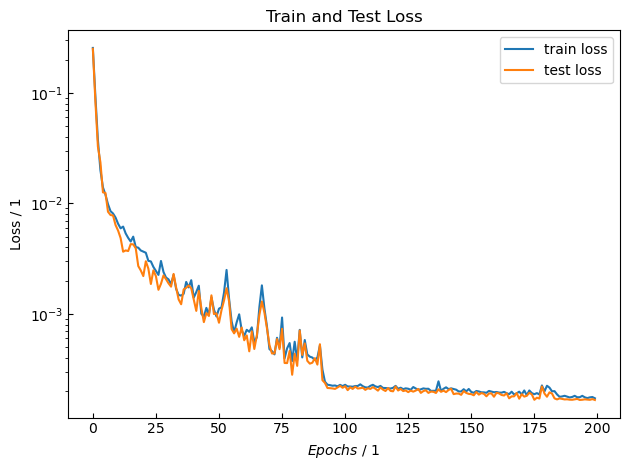

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.999869219550619 , R^2(NH3) = 0.9997776159803426
Test Dataset: R^2(H2) = 0.99985156324997 , R^2(NH3) = 0.9997783903094349
Max Error Training: |x_H2 - x_H2,pred| = 0.018710437821984505 , |x_NH3 - x_NH3,pred| = 0.0061429991325192
Max Error Test: |x_H2 - x_H2,pred| = 0.007529341146482571 , |x_NH3 - x_NH3,pred| = 0.00915688035910206


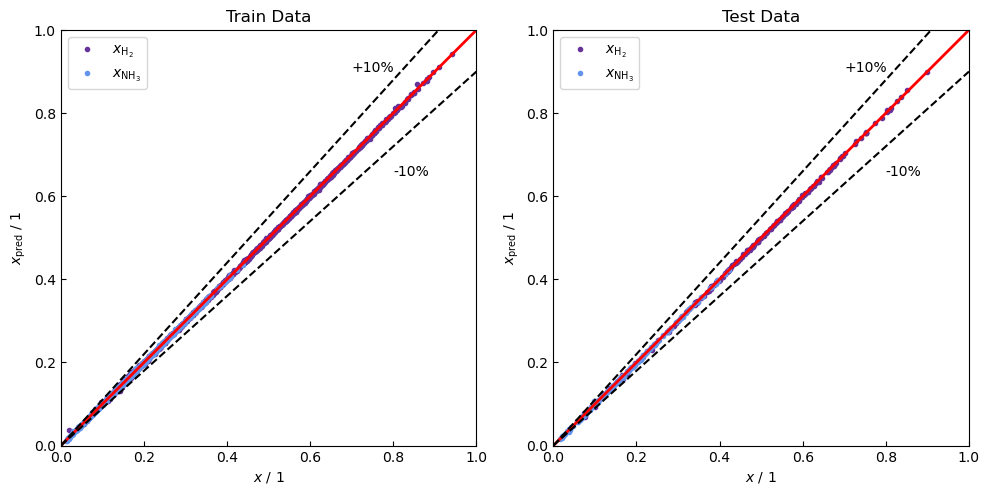

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

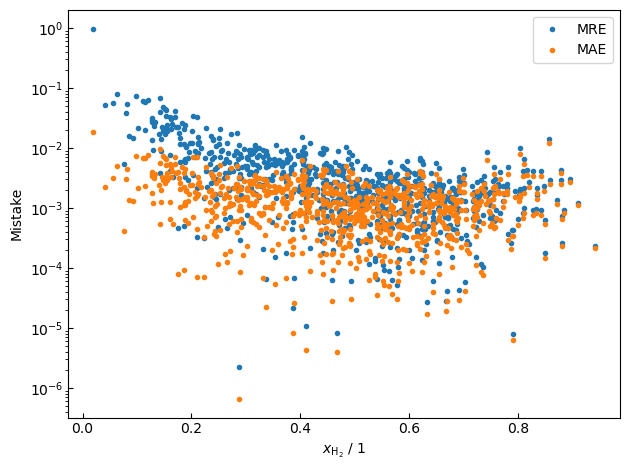

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

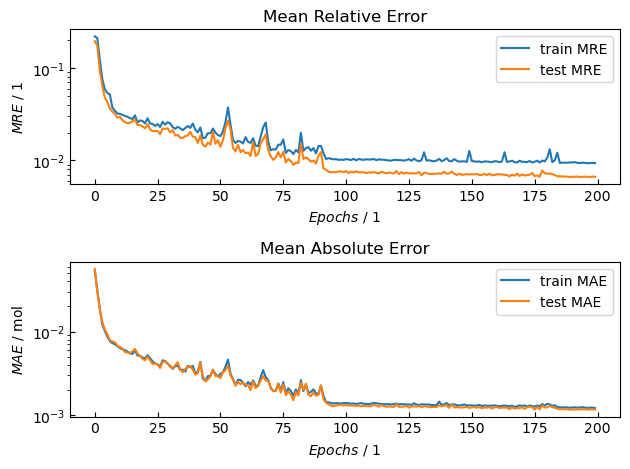

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

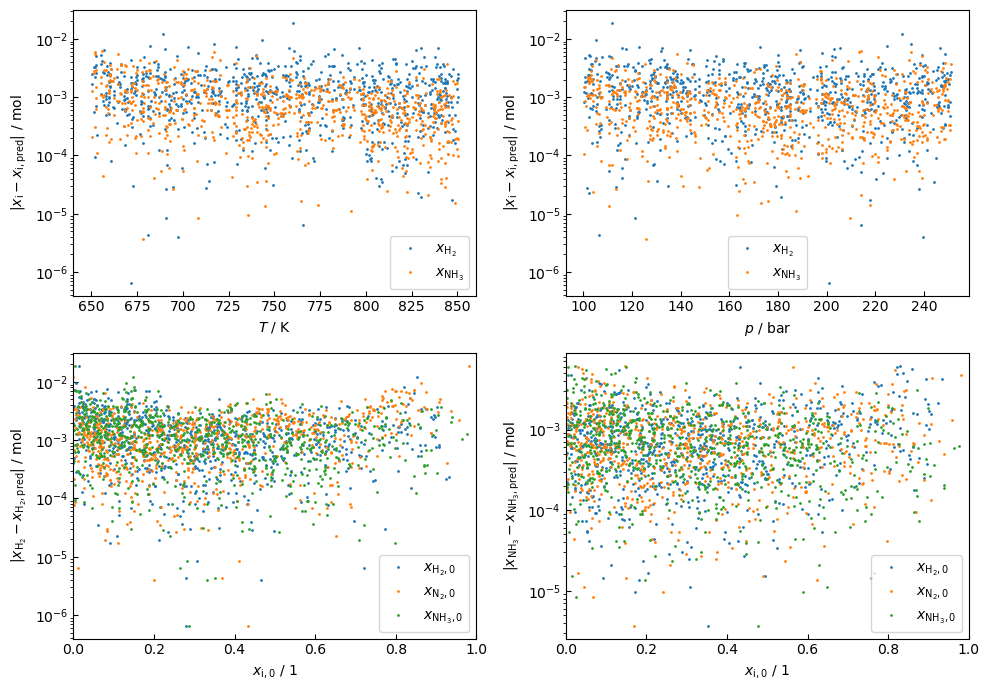

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

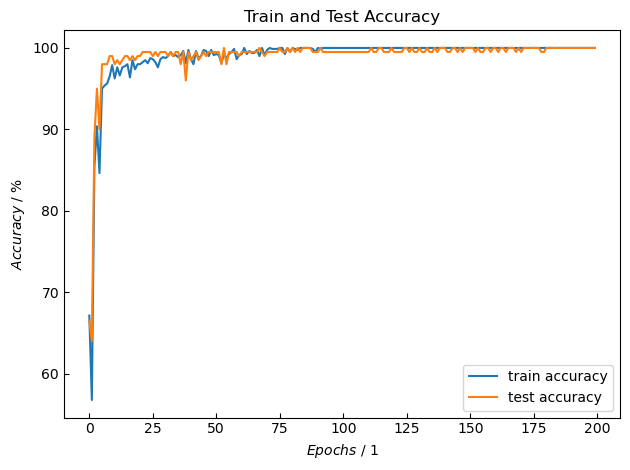

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.1185, -1.4866,  0.8446, -1.2502,  0.4489],
        [ 0.1465, -1.1116, -0.7342,  0.3940,  0.3179],
        [-0.8666,  0.6962, -0.3966,  0.0293,  0.3593],
        [-0.8278,  1.3647, -0.5390,  1.3985, -0.9005],
        [ 0.5427,  0.0982, -1.3514,  2.0746, -0.7942],
        [-1.1756, -1.0077, -0.5553,  1.7050, -1.1977],
        [ 0.6161,  0.4734, -0.1424, -1.0264,  1.1888],
        [ 1.4410, -1.2162,  2.4382, -1.2450, -1.1203],
        [-0.9528, -1.3571, -0.2601, -0.7591,  1.0312],
        [ 1.0330, -1.0847, -1.3381,  0.6343,  0.6649],
        [ 0.3820, -1.4799, -0.8625,  1.6130, -0.8021],
        [ 0.9186, -0.9760, -0.5186,  1.6286, -1.1556],
        [-0.3397, -0.2844, -0.6993, -0.3860,  1.0807],
        [-0.8627,  0.4546, -1.2893,  0.4200,  0.8360],
        [-1.4594,  1.2893, -0.1086,  0.2232, -0.1216],
        [-1.1599,  1.4961,  0.3057, -0.7505,  0.4671],
        [ 0.9036, -1.1231,  0.0584,  0.4135, -0.4800],
        [ 1.1900,  0.7035, -0.0235, -1.0976,  1.1448],
        [ 

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.4080,  0.1751,  0.2133, -0.7601, -0.3333],
         [ 0.3480,  0.0260,  0.4504, -0.4517, -0.1794],
         [ 0.0091,  0.0323,  0.5036, -0.5537,  0.2538],
         [ 0.4198, -0.4252,  0.0686,  0.2471,  0.3497],
         [-0.4034,  0.1596,  0.1808, -0.5907, -0.1307],
         [-0.3386,  0.0922, -0.2457,  0.1906, -0.0084],
         [ 0.2033,  0.2417, -0.1422, -0.1058, -0.2795],
         [ 0.1018, -0.1365,  0.5300, -0.1344,  0.3775],
         [ 0.5441, -0.2420,  0.1964,  0.3838,  0.0734],
         [-0.3615,  0.1287, -0.3796, -0.3066, -0.0459],
         [ 0.2488,  0.0362, -0.3233,  0.2406, -0.2440],
         [ 0.4064,  0.1032, -0.2189, -0.1033,  0.0546],
         [-0.5358,  0.1025, -0.2619, -0.5247, -0.0970],
         [-0.0643, -0.0279, -0.5059,  0.0191, -0.1035],
         [ 0.2339,  0.3170, -0.1296, -0.5043,  0.2486],
         [-0.0649, -0.0773,  0.1044,  0.4887, -0.2627],
         [-0.4280, -0.1043,  0.2906, -0.1737,  0.2088],
         [-0.3617,  0.268

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.9389, 0.2038, 0.9160, 0.3402, 0.2155],
        [0.3081, 0.1056, 0.7937, 0.1828, 0.4348]])
tensor([[ 0.5671, -0.7061],
        [ 0.5554, -0.3559]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 9.0468e-01, -9.3573e-01, -1.0592e+00,  2.1913e+00, -1.2002e+00],
        [ 9.2481e-01,  1.6671e+00, -4.2328e-01,  1.4710e+00, -1.0881e+00],
        [ 1.1297e+00, -9.0920e-01, -3.5516e-01, -4.9028e-01,  8.4965e-01],
        [-1.1275e+00,  1.2677e+00,  2.2394e+00, -1.3843e+00, -7.8291e-01],
        [-1.5536e+00, -9.1581e-01, -1.1906e+00, -1.0884e+00,  2.2808e+00],
        [-9.7360e-03,  6.5610e-01,  2.4583e-01, -1.0059e+00,  7.8687e-01],
        [-1.0617e+00,  1.7020e+00, -1.0571e+00, -1.2347e+00,  2.2994e+00],
        [ 1.1900e+00,  7.0348e-01, -2.3455e-02, -1.0976e+00,  1.1448e+00],
        [-1.0305e+00, -1.4174e+00,  4.7175e-01,  1.7148e-03, -4.6472e-01],
        [-1.0639e+00, -1.8903e-01, -1.3405e+00, -2.0662e-01,  1.5268e+00],
        [ 9.3939e-02, -9.9426e-01, -1.2815e+00,  6.2394e-01,  6.1997e-01],
        [-8.1088e-01, -1.4258e+00,  1.7382e+00, -7.5496e-01, -9.3421e-01],
        [-6.7233e-01,  9.3719e-01,  2.1455e-01,  5.1228e-01, -7.3414e-01],
        [-9.4457e-01,  1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

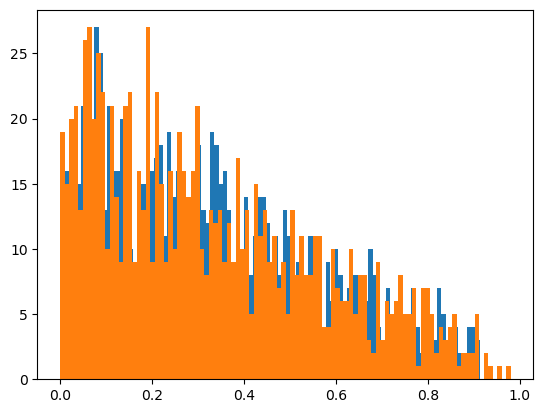

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_034.pth')
# np.savez('data/models/params_005_034.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)